<a href="https://colab.research.google.com/github/Yarida-nes/weatherwise-Yarida-Kaewthong/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [5]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai


In [6]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

Enter your API key: Perth


## 📦 Setup and Configuration
Import required packages and setup environment.

In [10]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
# ✅ Import after installing (if needed)
from fetch_my_weather import get_weather
from hands_on_ai.chat import get_response

# Add any other setup code here

In [8]:
!pip install pyinputplus

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyinputplus: filename=pyinputplus-0.2.12-py3-none-any.whl size=11348 sha256=51cd692f7b5d782393e92c89ee3927d16e7c32659238e6ac83584354acbd2e43
  Stored in directory: /root/.cache/pip/wheels/85/81/c1/325c8199c5c4de8a0b9af900ff9cd8bd69853e3d9419493512
  Created wheel for pysimplevalidate: filename=pysimplevalidate-0.2.12-py3-none-any.whl size=16225 sha256=e5655f28edaf6643f9ac38b19933495b6f1c1602fdbe4d95b65d4f55e56d355f
  Stored in directory: /root/.cache/pip/wheels/09/de/18/4dd2be0dbdf31870c6f0abde43b0de197b1c095655ad7da5c2
  Created wheel for stdiomask: filename=stdiomask

In [92]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 🌤️ Weather Data Functions

In [19]:
# Define get_weather_data() function here
def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including current conditions and forecast
    """
    try:
        data = get_weather(location)  # fetch data

        # Handle case where no data is returned
        if not data:
            return {"error": "Location not found"}

        # Access data as a dictionary
        data_dict = data.dict()

        # Keep only requested forecast days
        data_dict["forecast"] = data_dict.get("forecast", [])[:forecast_days]
        return data_dict

    except Exception as e:
        return {"error": str(e)}

In [82]:
import requests

def get_weather_data(location, forecast_days=3):
    """
    Retrieve weather data for a specified location using wttr.in API directly.
    """
    try:
        url = f"https://wttr.in/{location}?format=j1"
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        data = r.json()

        return {
            "location": location,
            "current": {
                "temp_C": data["current_condition"][0]["temp_C"],
                "humidity": data["current_condition"][0]["humidity"],
                "description": data["current_condition"][0]["weatherDesc"][0]["value"]
            },
            "forecast": data["weather"][:forecast_days]
        }
    except Exception as e:
        return {"error": str(e)}

## 📊 Visualisation Functions

In [103]:
# Define create_temperature_visualisation() here
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    forecast = weather_data.get("forecast", [])
    if not forecast:
        print("⚠️ No forecast data available to plot.")
        return

    days = [day["date"] for day in forecast]
    max_temps = [int(day.get("maxtempC") or day.get("maxTemp")) for day in forecast]
    min_temps = [int(day.get("mintempC") or day.get("minTemp")) for day in forecast]

    location = 'Unknown'
    nearest_area = weather_data.get('nearest_area', [{}])
    if nearest_area and isinstance(nearest_area[0], dict):
        area_name = nearest_area[0].get('areaName', [{}])
        if area_name and isinstance(area_name[0], dict):
             location = area_name[0].get('value', 'Unknown')


    fig, ax = plt.subplots()
    ax.plot(days, max_temps, label="Max Temp (°C)", marker="o", color="red")
    ax.plot(days, min_temps, label="Min Temp (°C)", marker="o", color="blue")
    ax.set_title(f"Temperature Forecast – {"Perth"}")
    ax.set_xlabel("Date")
    ax.set_ylabel("°C")
    ax.legend()

    if output_type == 'figure':
        return fig
    else:
        plt.show()

Forecast data: [{'astronomy': [{'moon_illumination': '4', 'moon_phase': 'Waxing Crescent', 'moonrise': '07:01 AM', 'moonset': '08:34 PM', 'sunrise': '06:04 AM', 'sunset': '06:14 PM'}], 'avgtempC': '20', 'avgtempF': '68', 'date': '2025-09-24', 'hourly': [{'DewPointC': '11', 'DewPointF': '52', 'FeelsLikeC': '18', 'FeelsLikeF': '64', 'HeatIndexC': '18', 'HeatIndexF': '64', 'WindChillC': '18', 'WindChillF': '64', 'WindGustKmph': '17', 'WindGustMiles': '11', 'chanceoffog': '0', 'chanceoffrost': '0', 'chanceofhightemp': '0', 'chanceofovercast': '0', 'chanceofrain': '0', 'chanceofremdry': '87', 'chanceofsnow': '0', 'chanceofsunshine': '92', 'chanceofthunder': '0', 'chanceofwindy': '0', 'cloudcover': '0', 'diffRad': '0.0', 'humidity': '64', 'precipInches': '0.0', 'precipMM': '0.0', 'pressure': '1026', 'pressureInches': '30', 'shortRad': '0.0', 'tempC': '18', 'tempF': '64', 'time': '0', 'uvIndex': '0', 'visibility': '10', 'visibilityMiles': '6', 'weatherCode': '113', 'weatherDesc': [{'value': '

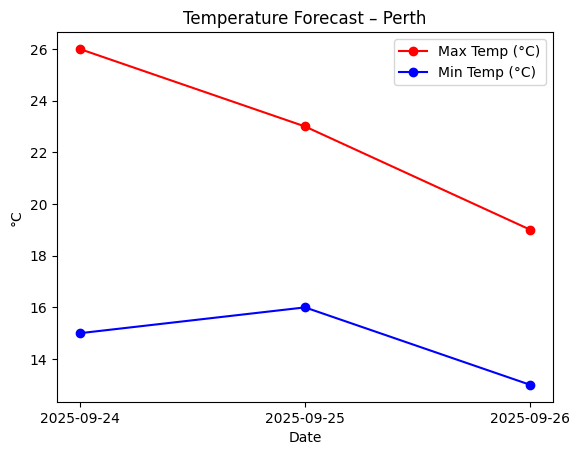

Temperature visualisation created.


In [104]:
sample = get_weather_data("Perth", forecast_days=3)
print("Forecast data:", sample.get("forecast"))

if sample.get("forecast"):
    create_temperature_visualisation(sample)
    print("Temperature visualisation created.")
else:
    print("⚠️ No forecast available for this location.")

In [105]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    forecast = weather_data.get("forecast", [])
    if not forecast:
        print("⚠️ No forecast data available to plot.")
        return

    days = [day["date"] for day in forecast]

    # pick the first hourly block’s chance of rain for each day
    precip = [int(day.get("hourly", [{}])[0].get("chanceofrain", 0)) for day in forecast]

    location = 'Unknown'
    nearest_area = weather_data.get('nearest_area', [{}])
    if nearest_area and isinstance(nearest_area[0], dict):
        area_name = nearest_area[0].get('areaName', [{}])
        if area_name and isinstance(area_name[0], dict):
             location = area_name[0].get('value', 'Unknown')


    fig, ax = plt.subplots()
    ax.bar(days, precip, color="skyblue")
    ax.set_title(f"Chance of Rain – {"Perth"}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Chance of Rain (%)")

    if output_type == 'figure':
        return fig
    else:
        plt.show()

Forecast data: [{'astronomy': [{'moon_illumination': '4', 'moon_phase': 'Waxing Crescent', 'moonrise': '07:01 AM', 'moonset': '08:34 PM', 'sunrise': '06:04 AM', 'sunset': '06:14 PM'}], 'avgtempC': '20', 'avgtempF': '68', 'date': '2025-09-24', 'hourly': [{'DewPointC': '11', 'DewPointF': '52', 'FeelsLikeC': '18', 'FeelsLikeF': '64', 'HeatIndexC': '18', 'HeatIndexF': '64', 'WindChillC': '18', 'WindChillF': '64', 'WindGustKmph': '17', 'WindGustMiles': '11', 'chanceoffog': '0', 'chanceoffrost': '0', 'chanceofhightemp': '0', 'chanceofovercast': '0', 'chanceofrain': '0', 'chanceofremdry': '87', 'chanceofsnow': '0', 'chanceofsunshine': '92', 'chanceofthunder': '0', 'chanceofwindy': '0', 'cloudcover': '0', 'diffRad': '0.0', 'humidity': '64', 'precipInches': '0.0', 'precipMM': '0.0', 'pressure': '1026', 'pressureInches': '30', 'shortRad': '0.0', 'tempC': '18', 'tempF': '64', 'time': '0', 'uvIndex': '0', 'visibility': '10', 'visibilityMiles': '6', 'weatherCode': '113', 'weatherDesc': [{'value': '

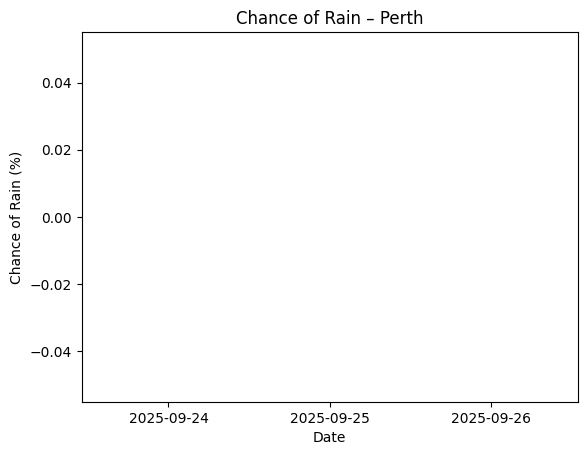

In [106]:
sample = get_weather_data("Perth", forecast_days=3)
print("Forecast data:", sample.get("forecast"))
create_precipitation_visualisation(sample)

## 🤖 Natural Language Processing

In [112]:
# Define parse_weather_question() and generate_weather_response() here
def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    q = question.lower()
    parsed = {"location": "Perth", "attribute": "temp", "time": "today"}

    # Time keywords
    if "tomorrow" in q:
        parsed["time"] = "tomorrow"

    # Attribute keywords
    if "rain" in q or "precip" in q:
        parsed["attribute"] = "rain"
    elif "humidity" in q:
        parsed["attribute"] = "humidity"
    elif "temp" in q or "hot" in q or "cold" in q:
        parsed["attribute"] = "temp"

    # Naive location detection: look for "in <city>"
    if " in " in q:
        maybe = q.split(" in ", 1)[1].split()[0]
        parsed["location"] = maybe.title()

    return parsed

def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.
    (Always about Perth)

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    attr = parsed_question["attribute"]
    time = parsed_question["time"].title()
    city = "Perth"

    # Choose which forecast day to use (0 = today, 1 = tomorrow)
    day_idx = 0 if parsed_question["time"] == "today" else 1
    forecast = weather_data.get("forecast", [])
    if not forecast:
        return f"Sorry, I couldn’t find a forecast for {city}."

    # Build responses
    if attr == "temp":
        return f"{time} in {city}, the temperature will be around {weather_data['current']['temp_C']}°C with {weather_data['current']['description'].lower()}."
    elif attr == "rain":
        chance = forecast[day_idx].get("hourly", [{}])[0].get("chanceofrain", "0")
        return f"{time} in {city}, the chance of rain is {chance}%."
    elif attr == "humidity":
        return f"{time} in {city}, the humidity is {weather_data['current']['humidity']}%."
    else:
        return "Sorry, I couldn't understand your question."

In [113]:
sample = get_weather_data("Perth", forecast_days=3)

q1 = "What is the temperature today in Perth?"
q2 = "Will it rain tomorrow in Perth?"
q3 = "What is the humidity today in Perth?"

for q in [q1, q2, q3]:
    parsed = parse_weather_question(q)
    print("Q:", q)
    print("Parsed:", parsed)
    print("Answer:", generate_weather_response(parsed, sample))
    print("-----")

Q: What is the temperature today in Perth?
Parsed: {'location': 'Perth?', 'attribute': 'temp', 'time': 'today'}
Answer: Today in Perth, the temperature will be around 29°C with sunny.
-----
Q: Will it rain tomorrow in Perth?
Parsed: {'location': 'Perth?', 'attribute': 'rain', 'time': 'tomorrow'}
Answer: Tomorrow in Perth, the chance of rain is 0%.
-----
Q: What is the humidity today in Perth?
Parsed: {'location': 'Perth?', 'attribute': 'humidity', 'time': 'today'}
Answer: Today in Perth, the humidity is 14%.
-----


## 🧭 User Interface

In [ ]:
# Define menu functions using pyinputplus or ipywidgets here

## 🧩 Main Application Logic

In [ ]:
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    pass

## 🧪 Testing and Examples

In [ ]:
# Include sample input/output for each function

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.